# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [0]:
!pip install tensorflow==2.0rc1

from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Unzipping My DATASET**


---


This will create a data directory. The hierarchy of this directory as shown below:

          data --+--> a
                 +--> b
                 :
                 :
                 +--> noise

In [0]:
!unzip data.zip
clear_output()

###**Function to show image**


---


"***imshow(image)***" function show image given as parameter

In [0]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [0]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [4]:
print(len(keywords))

41


###**Preparing Data for Training**

---



In [0]:
data_images = list()
labels = list()
i = 0
for c in keywords:
  path = 'data/{}/'.format(c)
  files = os.listdir(path)
  for name in files:
      img = cv2.imread(path+name)
      try:
        img = cv2.resize(img, (50, 50), interpolation = cv2.INTER_AREA)
      except:
        continue
      data_images.append(img)
      labels.append(i)
  i += 1


In [0]:
data_images = np.array(data_images)
labels = np.array(labels)

In [11]:
print(labels.shape, data_images.shape)

(23538,) (23538, 50, 50, 3)


###**Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   10% neuron Dropout Operation
5.   Dense Layer with 41 units




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (50, 50, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(keywords))
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               14745800  
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                8241      
Total params: 14,754,937
Trainable params: 14,754,937
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 2**

---



In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.fit(data_images, labels, epochs=4, callbacks = [callback])
clear_output()

In [16]:
test_loss, test_acc = model.evaluate(data_images,  labels, verbose=2)

print('\nTest accuracy:', test_acc)

23538/1 - 28s - loss: 0.0911 - accuracy: 0.9792

Test accuracy: 0.9792251




---


---





# **OCR Model Testing**


 

####**Adding Softmax Activation**

---



In [0]:
probablity = tf.keras.Sequential(
    model,
    tf.keras.layers.Softmax()
)

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [0]:
model.save('model.h5')
clear_output()

In [0]:
model = tf.keras.models.load_model('model.h5')

### **OCR Deployment Demo (Testing Model)**


---



#####**Some Conventions**

In [0]:
X = 0   # X coordinate of the character in image space
Y = 1   # Y coordinate of the character in image space
POS = 1    # shows and return the (x,y) coordinate of image space
SHAPE = 2  # shows and return the (width, height) of character contour in image space
W = 0 # width of the character
H = 1 # height of the character

#####"***check_in(c, region)***" checks if character is present in the given region "*region*" of the image space

In [0]:
def check_in(c, region):
    x, y, w, h = region
    center_x = c[POS][X]+c[SHAPE][W]/2
    center_y = c[POS][Y]
    if (center_x > x-1 and center_x < x+w+1) and (center_y > y-1 and center_y < y+h+1):
        return True
    return False

#####"***get_region(c, regions)***" finds the region in the given list of regions "*regions*" in image space and return it

In [0]:
def get_region(c, regions):
    for region in regions:
        if check_in(c, region):
          return region
    return False

#####"***sort_chars(line)***" Function to sort characters in given line

In [0]:
def sort_chars(line):
  res = list()
  while len(line) > 0:
    mx = 100000
    m = 0
    for c in line:
      if c[POS][X] <= mx:
        mx = c[POS][X]
        m = c
    line.remove(m)
    res.append(m)
  return res

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [0]:
def sort_lines_by_yval(lines):
  res = list()
  while len(lines) > 0:
    mn = 100000
    m = 0
    for line in lines:
      if line[0][POS][Y] < mn:
        mn = line[0][POS][Y]
        m = line
    lines.remove(m)
    res.append(m)
  return res

#####"***arrangeline(characters)***" Function to group characters in given image by lines

In [0]:
def group_chars_by_line(characters):
  lines = list()
  linei = 0
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[POS][Y]+c[SHAPE][H]/2 and c[POS][Y]+c[SHAPE][H]/2 <= my_plus_h:
              if my > c[POS][Y]:
                my = c[POS][Y]
              if my_plus_h < c[POS][Y]+c[SHAPE][H]:
                my_plus_h = c[POS][Y]+c[SHAPE][H]
              lines[linei].append(c)
              characters.remove(c)
      lines[linei]= sort_chars(lines[linei])
      linei += 1
      characters.remove(m)
  return lines

#####"**apply_ocr(img)**" is the function that does actual ocr operation on image parameter to get text

In [0]:
def apply_ocr(img):
    avg_h = 0
    character_list = list()
    color = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,21,10)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    img[:,:]=0
    i = 0
    for c in contours:
      try:
        x,y,w,h = cv2.boundingRect(c)
        try:
            show = color[y-2:y+h+2, x-2:x+w+2]
        except:
            show = color[y:y+h, x:x+w]
        test_data = cv2.resize(show,(50,50),interpolation = cv2.INTER_AREA)
        test_data=np.array([test_data])
        cmd = np.argmax(probablity.predict(test_data))
        if cmd < 40:
          avg_h += h
          cv2.rectangle(img, (x,y), (x+w+w//4, y+h), 255, -1)
          character_list.append([keywords[cmd], (x,y), (w,h)])
          i+= 1
        #cv2.imwrite('gen/'+keywords[cmd]+'/'+str(i)+'.jpg', show)
        #i+=1
      except:
            continue
    avg_h/=i
    text = group_chars_by_line(character_list)#, img)
    text = sort_lines_by_yval(text)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    regions = list()
    for cnt in contours:
      region = cv2.boundingRect(cnt)
      if region[3] <= avg_h*7:
        regions.append(region)
    del contours

    TEXT = ''
    for l in text:
      char = l[0]
      region = get_region(char, regions)
      if not region:
        continue
      for char in l:
        if not check_in(char, region):
          TEXT = TEXT + ' '
          r = get_region(char, regions)
          if not r:
            continue
          region = r
        TEXT = TEXT + char[0]
      TEXT = TEXT + '\n'
    return TEXT

#####**Main Run Start Point**

****************************** Text on 2.jpg ******************************


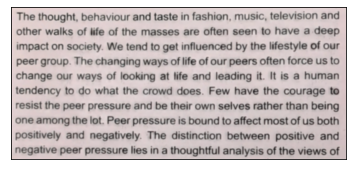

The thought behavlour and taste ln fashion mus c iedevlslon and
other valks of llfe of the masses are often seen lo have a deep
lmpact on s ety we telnd to gel nauenced by the llfestyle of our
peer groun The changlng vays of l fe of our peers often force us to
change our ways of looklng at llfe and leadlng lt l t ls a human
tendensy lo do what lhe crowd does Few have the courage lo
reslsl lhe peer pressure and be lhelr o vn selves rather than belng
one among the lot peer pressure ls bound to a fect most of us both
posltlvely and negatlvely The dlsllnctlon beveen posltlve and
negat ve peer pressure lles ln a thoughtful analysls of the vlews of

-------------------------------------------------------------------------------- 


****************************** Text on 1.jpg ******************************


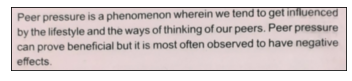

peer pressure ls a phenomenon wherel n we tend lo get lnauenced
by lhe Ilfestyle and the ways of thlnklng of our peers peer pressure
n prove benefclal but lt ls most o len obse ed to have negatlve
effects

-------------------------------------------------------------------------------- 




In [46]:
imgs = [f for f in os.listdir('.') if f.endswith('.jpg')]
img_no = 0
for img in imgs:
    print('*'*30, 'Text on {}'.format(img), '*'*30)
    img = cv2.imread(img)
    TEXT = apply_ocr(img)
    imshow(img)
    print(TEXT)
    print('-'*80, '\n\n')
    img_no += 1